Based on:
* [Modelling chemical reactions on a quantum computer](https://pennylane.ai/qml/demos/tutorial_chemical_reactions/)

Modelling chemical reactions on a quantum computer
==================================================
*Authors: Varun Rishi and Juan Miguel Arrazola --- Posted: 23 July 2021.
Last updated: 21 February 2023.*

The term \"chemical reaction\" is another name for the transformation of molecules -- the breaking and forming of bonds. They are characterized by an energy barrier that determines the likelihood that a reaction takes place. The energy landscapes formed by these barriers are the key to understanding how chemical reactions occur, at the deepest possible level.

In this tutorial, you will learn how to use PennyLane to simulate chemical reactions by constructing potential energy surfaces for molecular transformations. In the process, you will learn how quantum computers can be used to calculate equilibrium bond lengths, activatio energy barriers, and reaction rates. As illustrative examples, we use tools implemented in PennyLane to study diatomic bond dissociation and reactions involving the exchange of hydrogen atoms.

Potential Energy Surfaces
-------------------------

[Potential energy surfaces
(PES)](https://en.wikipedia.org/wiki/Potential_energy_surface) describe the energy of molecules for different positions of its atoms. The concept originates from the fact that the electrons are much lighter than protons and neutrons, so they will adjust instantaneously to the new positions of the nuclei. This leads to a separation of the nuclear and electronic parts of the Schrödinger equation, meaning we only need to solve the electronic equation:

$$H(R)|\Psi \rangle =  E|\Psi\rangle.$$

From this perspective arises the concept of the electronic energy of a molecule, $E(R)$, as a function of nuclear coordinates $R$. The energy $E(R)$ is the expectation value of the molecular Hamiltonian, $E(R)=\langle \Psi_0|H(R)|\Psi_0\rangle$, taken with respect to the ground state $|\Psi_0(R)\rangle$. The potential energy surface is precisely this function $E(R)$, which connects energies to different geometries of the molecule. It gives us a visual tool to understand chemical reactions by associating stable molecules (reactants and products) with local minima, transition states with peaks, and by identifying the possible routes for a chemical reaction to occur.

To build the potential energy surface, we compute the energy for fixed positions of the nuclei, and subsequently adjust the positions of the nuclei in incremental steps, computing the energies at each new configuration. The obtained set of energies corresponds to a grid of nuclear positions and the plot of $E(R)$ gives rise to the potential
energy surface.

![Illustration of a potential energy surface for a diatomic
molecule.](./images/Chemical_reactions_1.png)

Bond dissociation in a Hydrogen molecule
----------------------------------------

We now construct a potential energy surface and use it to compute equilibrium bond lengths and the bond dissociation energy. We begin with the simplest of molecules: $H_2$. The formation or breaking of the $H-H$ bond is also the most elementary of all reactions:

$$H_2 \rightarrow H + H.$$

Using a minimal [basis set](https://en.wikipedia.org/wiki/STO-nG_basis_sets), this molecular system can be described by two electrons in four spin-orbitals. When mapped to a qubit representation, we need a total of four qubits. The *Hartree-Fock (HF) state* is represented as $|1100\rangle$, where the two lowest-energy orbitals are occupied, and the remaining two are unoccupied.

We design a quantum circuit consisting of `~.pennylane.SingleExcitation`{.interpreted-text role="class"} and `~.pennylane.DoubleExcitation`{.interpreted-text role="class"} gates applied to the Hartree-Fock state. This circuit will be optimized to prepare ground states for different configurations of the molecule.

In [1]:
import pennylane as qml
from pennylane import qchem

# Hartree-Fock state
hf = qml.qchem.hf_state(electrons=2, orbitals=4)
hf

tensor([1, 1, 0, 0], requires_grad=True)

To construct the potential energy surface, we vary the location of the nuclei and calculate the energy for each resulting geometry of the
molecule. We keep an $H$ atom fixed at the origin and change only the coordinate of the other atom in a single direction. The potential energy surface is then a one-dimensional function depending only on the bond length, i.e., the separation between the atoms. For each value of the bond length, we construct the corresponding Hamiltonian, then optimize the circuit using gradient descent to obtain the ground-state energy. We vary the bond length in the range $0.5$ to $5.0$ [Bohrs](https://en.wikipedia.org/wiki/Bohr_radius) in steps of $0.25$ Bohr. This covers the point where the $H-H$ bond is formed, the equilibrium bond length, and the point where the bond is broken, which occurs when the atoms are far away from each other.


In [2]:
from pennylane import numpy as np

# atomic symbols defining the molecule
symbols=['H','H']
# list to store energies
energies = []
# set up a loop to change bond length
r_range = np.arange(0.5,5.0,0.25)
# keeps track of points in the potential energy surface
pes_point = 0
params_old = 0
min_energy = 0
indx = 0

We build the Hamiltonian using the molecular_hamiltonian() function, and use standard Pennylane techniques to optimize the circuit.

In [12]:
for r in r_range:
    # Change only the z coordinate of one atom
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])
    #Obtain the qubit Hamiltonian method= 'dhf'
    H, qubits  = qchem.molecular_hamiltonian(symbols, coordinates, method= 'dhf')
    # define the device, optimizer and circuit
    dev = qml.device("default.qubit", wires=qubits)
    opt = qml.GradientDescentOptimizer(stepsize = 0.4)

    @qml.qnode(dev,interface = 'autograd')
    def circuit(parameters):
        # Prepare the HF state
        qml.BasisState(hf, wires=range(qubits))
        qml.DoubleExcitation(parameters[0], wires=[0, 1, 2, 3])
        qml.SingleExcitation(parameters[1], wires=[0, 2])
        qml.SingleExcitation(parameters[2], wires=[1, 3])

        return qml.expval(H) # we are interested in minimizing this expectation value
    # initialize the gate parameters
    params = np.zeros(3, requires_grad=True)

    # initialize with converged
    if pes_point > 0:
        params = params_old
    prev_energy = 0.0
    for n in range(50):
        # perform optimization step
        params,energy = opt.step_and_cost(circuit,params)
        if np.abs(energy - prev_energy) < 1e-6:
            break
        prev_energy = energy
    # store the converged parameters
    params_old = params
    pes_point = pes_point + 1
    energies.append(energy)
    if min_energy > energy:
        min_energy = energy
        indx = energies.index(energy)
    print(f'Energy:{energy} to r:{r}')


Energy:-0.4107883961175878 to r:0.5
Energy:-0.907722823531667 to r:0.75
Energy:-1.0789696152155244 to r:1.0
Energy:-1.1319129288479872 to r:1.25
Energy:-1.13468979388184 to r:1.5
Energy:-1.1158993531817398 to r:1.75
Energy:-1.088495097286535 to r:2.0
Energy:-1.0588181410037876 to r:2.25
Energy:-1.030471975675673 to r:2.5
Energy:-1.005580295128583 to r:2.75
Energy:-0.9851540357530233 to r:3.0
Energy:-0.9693332619768962 to r:3.25
Energy:-0.9576724007151391 to r:3.5
Energy:-0.9494230988959085 to r:3.75
Energy:-0.9437750480325594 to r:4.0
Energy:-0.9400014108792629 to r:4.25
Energy:-0.9375233257068576 to r:4.5
Energy:-0.9359175211268949 to r:4.75


This is the potential energy surface for the dissociation of a hydrogen molecule into two hydrogen atoms. It is a numerical calculation of the same type of plot that was illustrated in the beginning. In a diatomic molecule such as $H_2$, it can be used to obtain the equilibrium bond length --- the distance between the two atoms that minimizes the total electronic energy. This is simply the minimum of the curve. We can also obtain the bond dissociation energy, which is the difference in the energy of the system when the atoms are far apart and the energy at equilibrium. At sufficiently large separations, the atoms no longer form a molecule, and the system is called \"dissociated\".

Let\'s use our results to compute the equilibrium bond length and the
bond dissociation energy:


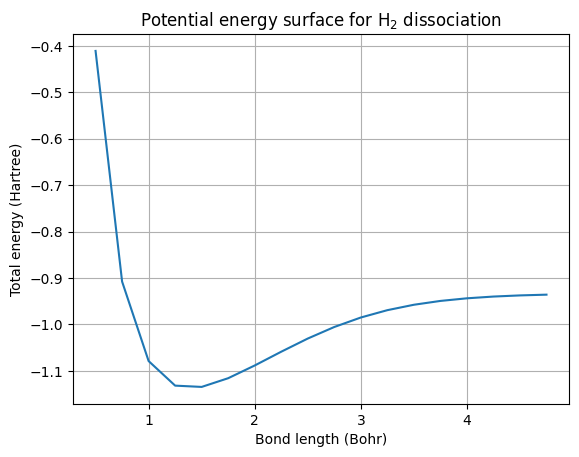

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(r_range, energies)

ax.set(
    xlabel="Bond length (Bohr)",
    ylabel="Total energy (Hartree)",
    title="Potential energy surface for H$_2$ dissociation",
)
ax.grid()
plt.show()

In [13]:
# equilibrium energy
e_eq = min(energies)
# energy when atoms are far apart
e_dis = energies[-1]

# Bond dissociation energy
bond_energy = e_dis - e_eq

# Equilibrium bond length
idx = energies.index(e_eq)
bond_length = r_range[idx]

print(f"The equilibrium bond length is {bond_length:.1f} Bohrs")
print(f"The bond dissociation energy is {bond_energy:.6f} Hartrees")

The equilibrium bond length is 1.5 Bohrs
The bond dissociation energy is 0.198772 Hartrees


Hydrogen Exchange Reaction
==========================

After studying a simple diatomic bond dissociation, we move to a
slightly more complicated case: a hydrogen exchange reaction.

$$H_2 + H \rightarrow H + H_2.$$

This reaction has a barrier, the [transition
state](https://en.wikipedia.org/wiki/Transition_state), that must be
crossed for the exchange of an atom to be complete. In this case, the
transition state corresponds to a specific linear arrangement of the
atoms where one $H-H$ bond is partially broken and the other $H-H$ bond
is partially formed. The molecular movie ⚛️🎥 below is an illustration of
the reaction trajectory. It depicts how the distance between the
hydrogen atoms changes as one bond is broken and another one is formed.
The path along which the reaction proceeds is known as the [reaction
coordinate](https://en.wikipedia.org/wiki/Reaction_coordinate).

![static](images/h3_mol_movie.gif)

In a minimal basis like STO-3G, this system consists of three electrons
in six spin molecular orbitals. This translates into a six-qubit
problem, for which the Hartree-Fock state is $|111000\rangle$. As there
is an unpaired electron, the spin multiplicity is equal to two and needs
to be specified, since it differs from the default value of one.


In [ ]:
symbols = ["H", "H", "H"]
multiplicity = 2

To build a potential energy surface for the hydrogen exchange, we fix the positions of the outermost atoms, and change only the placement of the middle atom. For this circuit, we employ all single and double excitation gates, which can be conveniently done with the AllSinglesDoubles template. The rest of the procedure follows as before.

In [21]:
symbols = ["H", "H",]
multiplicity = 2

In [23]:
from pennylane.templates import AllSinglesDoubles

energies = []
pes_point = 0
params_old = 0
# get all the singles and doubles excitations, and Hartree-Fock state
electrons = 3
orbitals = 6
singles, doubles = qchem.excitations(electrons, orbitals)
hf = qml.qchem.hf_state(electrons, orbitals)
# l# loop to change reaction coordinate
r_range = np.arange(1.0, 3.0, 0.1)
for r in r_range:
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r, 0.0, 0.0, 0.0,0.0, 0.0, 0.0])
    # We now specify the multiplicity
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, method='dhf')

    dev = qml.device("default.qubit", wires=qubits)
    opt = qml.GradientDescentOptimizer(stepsize=1.5)
    @qml.qnode(dev, interface='autograd')
    def circuit(parameters):
        AllSinglesDoubles(parameters, range(qubits), hf, singles, doubles)
        return qml.expval(H)  # we are interested in minimizing this expectation value
    params = np.zeros(len(singles) + len(doubles), requires_grad=True)
    prev_energy = 0.0

    for n in range(60):
        params, energy = opt.step_and_cost(circuit, params)
        if np.abs(energy - prev_energy) < 1e-6:
            break
        prev_energy = energy

    # store the converged parameters
    params_old = params
    pes_point = pes_point + 1

    energies.append(energy)
    print(f'Energy:{energy} to r:{r}')

C:\Users\marty\anaconda3\envs\PennyLane_1\lib\site-packages\autoray\autoray.py:80: RuntimeWarning: invalid value encountered in sqrt
  return get_lib_fn(backend, fn)(*args, **kwargs)


LinAlgError: Eigenvalues did not converge

[how-to-use-the-hartree-fock-method-in-pennylane](https://pennylane.ai/blog/2022/09/how-to-use-the-hartree-fock-method-in-pennylane/)

In [3]:
symbols = ['H', 'H']

In [4]:
d = 1.0

geometry = np.array([
    [0.0, 0.0, -d/2], # First nuclear position
    [0.0, 0.0,  d/2]], # Second nuclear position
    requires_grad=True
)
alpha = np.array([
    [3.42525091, 0.62391373, 0.1688554],
    [3.42525091, 0.62391373, 0.1688554]],
    requires_grad = True
)

coeffs = np.array([
    [0.15432897, 0.53532814, 0.44463454],
    [0.15432897, 0.53532814, 0.44463454]],
    requires_grad = True
)

In [32]:
molecule = qchem.Molecule(symbols, geometry, alpha=alpha, coeff=coeffs)
molecule

<Molecule = H2, Charge: 0, Basis: STO-3G, Orbitals: 2, Electrons: 2>

In [9]:
part = qml.data.load("qchem", molname="LiH", basis="STO-3G")[0]
part.molecule

<Molecule = HLi, Charge: 0, Basis: STO-3G, Orbitals: 6, Electrons: 4>

In [11]:
qml.data.list_attributes(data_name="qchem")

['molname',
 'basis',
 'bondlength',
 'molecule',
 'hf_state',
 'hamiltonian',
 'sparse_hamiltonian',
 'meas_groupings',
 'fci_energy',
 'fci_spectrum',
 'dipole_op',
 'number_op',
 'spin2_op',
 'spinz_op',
 'symmetries',
 'paulix_ops',
 'optimal_sector',
 'tapered_hamiltonian',
 'tapered_hf_state',
 'tapered_dipole_op',
 'tapered_num_op',
 'tapered_spin2_op',
 'tapered_spinz_op',
 'vqe_gates',
 'vqe_params',
 'vqe_energy']

In [12]:
part = qml.data.load("qchem", molname="Li2", basis="STO-3G", bondlength = 3.5)[0]
part.molecule

<Molecule = Li2, Charge: 0, Basis: STO-3G, Orbitals: 10, Electrons: 6>

In [ ]:
qml.data.load("qchem", molname="Li2", bondlength=3.5, basis="STO-3G", attributes=["basis", "hamiltonian", "molecule", "hf_state", "vqe_energy"])